In [ ]:
!pip install tensorflow-gpu==2.0.0-rc1

In [1]:
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
class MaskedConv2D(tf.keras.layers.Layer):
    """Convolutional layers with masks for autoregressive models

    Convolutional layers with simple implementation to have masks type A and B.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B'}
        self.mask_type = mask_type

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=(self.kernel_size,
                                             self.kernel_size,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight("bias",
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        mask = np.ones(self.kernel.shape, dtype=np.float32)
        mask[self.kernel_size // 2, self.kernel_size // 2 + (self.mask_type == 'B'):, :, :] = 0.
        mask[self.kernel_size // 2 + 1:, :, :] = 0.

        self.mask = tf.constant(mask, dtype=tf.float32, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = tf.nn.conv2d(input, masked_kernel, strides=[1, self.strides, self.strides, 1], padding=self.padding)
        x = tf.nn.bias_add(x, self.bias)
        return x

In [3]:
class ResidualBlock(tf.keras.Model):
    """Residual blocks that compose pixelCNN

    Blocks of layers with 3 convolutional layers and one residual connection.
    Based on Figure 5 from [1] where h indicates number of filters.

    Refs:
    [1] - Oord, A. V. D., Kalchbrenner, N., & Kavukcuoglu, K. (2016). Pixel
     recurrent neural networks. arXiv preprint arXiv:1601.06759.
    """

    def __init__(self, h):
        super(ResidualBlock, self).__init__(name='')

        self.conv2a = keras.layers.Conv2D(filters=h, kernel_size=1, strides=1)
        self.conv2b = MaskedConv2D(mask_type='B', filters=h, kernel_size=3, strides=1)
        self.conv2c = keras.layers.Conv2D(filters=2 * h, kernel_size=1, strides=1)

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv2a(x)

        x = tf.nn.relu(x)
        x = self.conv2b(x)

        x = tf.nn.relu(x)
        x = self.conv2c(x)

        x += input_tensor
        return x

In [4]:
def quantisize(images, q_levels):
    """Digitize image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')

In [5]:
# --------------------------------------------------------------------------------------------------------------
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [6]:
# --------------------------------------------------------------------------------------------------------------
# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

height = 32
width = 32
n_channel = 3

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, n_channel)
x_test = x_test.reshape(x_test.shape[0], height, width, n_channel)

In [9]:
# --------------------------------------------------------------------------------------------------------------
# Quantisize the input data in q levels
q_levels = 64
x_train_quantised = quantisize(x_train, q_levels)
x_test_quantised = quantisize(x_test, q_levels)

In [10]:
# --------------------------------------------------------------------------------------------------------------
# Creating input stream using tf.data API
batch_size = 128
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

In [11]:
# --------------------------------------------------------------------------------------------------------------
# Create PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=128, kernel_size=7, strides=1)(inputs)

for i in range(15):
    x = ResidualBlock(h=64)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=n_channel * q_levels, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

In [12]:
# --------------------------------------------------------------------------------------------------------------
# Prepare optimizer and loss function
lr_decay = 0.9999
learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [13]:
# --------------------------------------------------------------------------------------------------------------
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

In [14]:
# --------------------------------------------------------------------------------------------------------------
# Training loop
n_epochs = 100
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    start_epoch = time.time()
    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)
        iter_time = time.time() - start
        if i_iter % 100 == 0:
            print('EPOCH {:3d}: ITER {:4d}/{:4d} TIME: {:.2f} LOSS: {:.4f}'.format(epoch,
                                                                                   i_iter, n_iter,
                                                                                   iter_time,
                                                                                   loss))
    epoch_time = time.time() - start_epoch
    print('EPOCH {:3d}: TIME: {:.2f} ETA: {:.2f}'.format(epoch,
                                                         epoch_time,
                                                         epoch_time * (n_epochs - epoch)))

EPOCH   0: ITER    0/ 391 TIME: 6.18 LOSS: 4.1608
EPOCH   0: ITER  100/ 391 TIME: 0.17 LOSS: 3.2702
EPOCH   0: ITER  200/ 391 TIME: 0.17 LOSS: 2.9923
EPOCH   0: ITER  300/ 391 TIME: 0.17 LOSS: 2.8036
EPOCH   0: TIME: 76.23 ETA: 7622.51
EPOCH   1: ITER    0/ 391 TIME: 0.09 LOSS: 2.6291
EPOCH   1: ITER  100/ 391 TIME: 0.17 LOSS: 2.5464
EPOCH   1: ITER  200/ 391 TIME: 0.17 LOSS: 2.5260
EPOCH   1: ITER  300/ 391 TIME: 0.17 LOSS: 2.5295
EPOCH   1: TIME: 67.15 ETA: 6648.30
EPOCH   2: ITER    0/ 391 TIME: 0.09 LOSS: 2.4201
EPOCH   2: ITER  100/ 391 TIME: 0.17 LOSS: 2.3586
EPOCH   2: ITER  200/ 391 TIME: 0.17 LOSS: 2.4149
EPOCH   2: ITER  300/ 391 TIME: 0.17 LOSS: 2.4034
EPOCH   2: TIME: 67.59 ETA: 6623.43
EPOCH   3: ITER    0/ 391 TIME: 0.09 LOSS: 2.3649
EPOCH   3: ITER  100/ 391 TIME: 0.17 LOSS: 2.2904
EPOCH   3: ITER  200/ 391 TIME: 0.17 LOSS: 2.3985
EPOCH   3: ITER  300/ 391 TIME: 0.17 LOSS: 2.3079
EPOCH   3: TIME: 67.89 ETA: 6584.92
EPOCH   4: ITER    0/ 391 TIME: 0.09 LOSS: 2.2521
EPOCH 

EPOCH  34: TIME: 68.31 ETA: 4508.42
EPOCH  35: ITER    0/ 391 TIME: 0.09 LOSS: 1.9871
EPOCH  35: ITER  100/ 391 TIME: 0.17 LOSS: 1.9548
EPOCH  35: ITER  200/ 391 TIME: 0.17 LOSS: 2.0548
EPOCH  35: ITER  300/ 391 TIME: 0.17 LOSS: 2.0310
EPOCH  35: TIME: 68.09 ETA: 4425.76
EPOCH  36: ITER    0/ 391 TIME: 0.09 LOSS: 1.9848
EPOCH  36: ITER  100/ 391 TIME: 0.17 LOSS: 1.9510
EPOCH  36: ITER  200/ 391 TIME: 0.17 LOSS: 2.0505
EPOCH  36: ITER  300/ 391 TIME: 0.17 LOSS: 2.0170
EPOCH  36: TIME: 68.28 ETA: 4369.78
EPOCH  37: ITER    0/ 391 TIME: 0.09 LOSS: 1.9764
EPOCH  37: ITER  100/ 391 TIME: 0.17 LOSS: 1.9436
EPOCH  37: ITER  200/ 391 TIME: 0.17 LOSS: 2.0488
EPOCH  37: ITER  300/ 391 TIME: 0.17 LOSS: 2.0200
EPOCH  37: TIME: 68.12 ETA: 4291.60
EPOCH  38: ITER    0/ 391 TIME: 0.09 LOSS: 1.9788
EPOCH  38: ITER  100/ 391 TIME: 0.17 LOSS: 1.9414
EPOCH  38: ITER  200/ 391 TIME: 0.17 LOSS: 2.0460
EPOCH  38: ITER  300/ 391 TIME: 0.17 LOSS: 2.0129
EPOCH  38: TIME: 68.20 ETA: 4228.23
EPOCH  39: ITER    0

EPOCH  69: ITER  300/ 391 TIME: 0.17 LOSS: 1.9806
EPOCH  69: TIME: 68.15 ETA: 2112.79
EPOCH  70: ITER    0/ 391 TIME: 0.09 LOSS: 1.9432
EPOCH  70: ITER  100/ 391 TIME: 0.18 LOSS: 1.9073
EPOCH  70: ITER  200/ 391 TIME: 0.17 LOSS: 2.0203
EPOCH  70: ITER  300/ 391 TIME: 0.17 LOSS: 1.9795
EPOCH  70: TIME: 68.24 ETA: 2047.12
EPOCH  71: ITER    0/ 391 TIME: 0.09 LOSS: 1.9430
EPOCH  71: ITER  100/ 391 TIME: 0.17 LOSS: 1.9079
EPOCH  71: ITER  200/ 391 TIME: 0.17 LOSS: 2.0191
EPOCH  71: ITER  300/ 391 TIME: 0.17 LOSS: 1.9793
EPOCH  71: TIME: 68.05 ETA: 1973.38
EPOCH  72: ITER    0/ 391 TIME: 0.09 LOSS: 1.9430
EPOCH  72: ITER  100/ 391 TIME: 0.17 LOSS: 1.9063
EPOCH  72: ITER  200/ 391 TIME: 0.17 LOSS: 2.0188
EPOCH  72: ITER  300/ 391 TIME: 0.17 LOSS: 1.9787
EPOCH  72: TIME: 68.15 ETA: 1908.33
EPOCH  73: ITER    0/ 391 TIME: 0.09 LOSS: 1.9423
EPOCH  73: ITER  100/ 391 TIME: 0.17 LOSS: 1.9060
EPOCH  73: ITER  200/ 391 TIME: 0.17 LOSS: 2.0190
EPOCH  73: ITER  300/ 391 TIME: 0.17 LOSS: 1.9782
EPOCH 

In [15]:
# --------------------------------------------------------------------------------------------------------------
# Test
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = pixelcnn(batch_x, training=False)
    logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
    logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / (height * width)))


nll : 1.9808398485183716 nats
bits/dim : 0.0019344139145687222


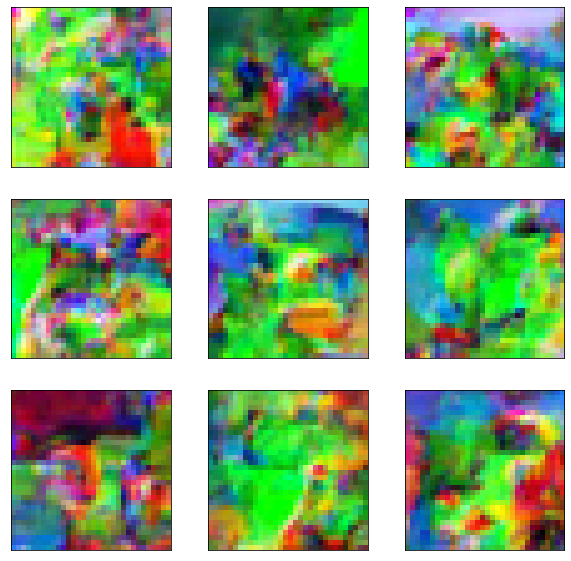

In [27]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
samples = np.zeros((9, height, width, n_channel), dtype='float32')
for i in range(height):
    for j in range(width):
        for k in range(n_channel):
            logits = pixelcnn(samples)
            logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
            logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
            next_sample = tf.random.categorical(logits[:, i, j, k, :], 1)
            samples[:, i, j, k] = (next_sample.numpy() / (q_levels - 1))[:, 0]
            

fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(samples[i, :, :, :])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()